<a href="https://colab.research.google.com/github/sunilvengalil/BloodVesselSegment/blob/master/fundal_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing Google colab

1.   Go to google colab
> `https://colab.research.google.com/notebooks/intro.ipynb`
3.   Create a new notebook using menu `File` -> `New Notebook`
4.   Rename the notebook to `fundal_image_segmentation.ipynb`
5.   Change the runtime enviroment to `GPU` 
> Go to Menu `Runtime` -> `Change Runtime type`. From the dropdown select `GPU`. Click on `Save` button  

# Import all packages used

In [2]:
import os
import random

import numpy as np
from PIL import Image
import h5py
from six.moves import configparser

from matplotlib import pyplot as plt
from google.colab import drive

import cv2

import torch
import torch.nn.functional as F  # Various activation functions
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn


%matplotlib inline


# 1. Mount google drive
Mount `MyDrive` in your google drive as  `/content/gdrive`

While running the following cell, you will be prompted to click on a link in order to generate access key to access your google drive. 

Copy paste the acess key into the input field and press Enter

In [5]:
drive.mount("/content/gdrive")

KeyboardInterrupt: ignored

Check the current working directory and list the files/folders in current directory. Make sure `gdive` is mounted

In [ ]:
!pwd
!ls -ltr

# 2. Get the code from github

Create a new directory `fundal_image` and download code and data from github `https://github.com/juntang-zhuang/LadderNet.git`

The above code is implementation of paper
[LADDERNET: MULTI-PATH NETWORKS BASED ON U-NET FOR MEDICAL IMAGE
SEGMENTATION](https://arxiv.org/pdf/1810.07810v4.pdf)

In [ ]:
%cd /content/gdrive/MyDrive
#!mkdir fundal_image
%cd fundal_image
#!git clone https://github.com/juntang-zhuang/LadderNet.git

# 3. Display sample training image from DRIVE dataset

In [44]:
!ls /content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/images

21_training.tif  26_training.tif  31_training.tif  36_training.tif
22_training.tif  27_training.tif  32_training.tif  37_training.tif
23_training.tif  28_training.tif  33_training.tif  38_training.tif
24_training.tif  29_training.tif  34_training.tif  39_training.tif
25_training.tif  30_training.tif  35_training.tif  40_training.tif


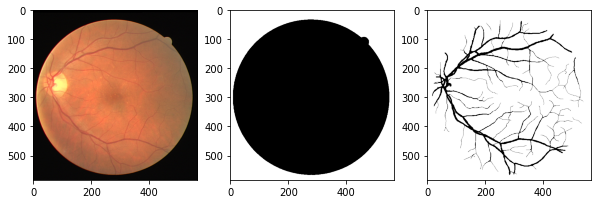

In [45]:
train_img = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/images/21_training.tif")
train_mask = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/mask/21_training_mask.gif")
train_gt = Image.open("/content/gdrive/MyDrive/fundal_image/LadderNet/DRIVE/training/1st_manual/21_manual1.gif")

fig = plt.figure(figsize= (10,20))
ax = fig.add_subplot(1, 3, 1 )
ax.imshow(train_img)
ax2 = fig.add_subplot(1, 3, 2 )
ax2.imshow(train_mask, cmap="Greys")
ax3 = fig.add_subplot(1, 3, 3 )
ax3.imshow(train_gt, cmap="Greys")

plt.show()


# 4. Edit the configuration file

Open the file `gdrive/Mydrive/fundal_image/LadderNet/` configuration.txt and modify the values of following configuration parameters to below mentioned values

```
root_path = "/content/gdrive/MyDrive/fundal_image/LadderNet/"
path_local =  DRIVE_datasets_training_testing/
N_subimgs=1900
N_epochs = 100
Batch_size=32
average_mode = False
```






# 5. Load configuration settings

In [46]:
#=========  Load settings from Config file
root_path = "/content/gdrive/MyDrive/fundal_image/LadderNet/"
config = configparser.RawConfigParser()
config.read(root_path + '/configuration.txt')
dataset_path = root_path + "DRIVE_datasets_training_testing/"

#Experiment name
name_experiment = config.get('experiment name', 'name')
#training settings
N_epochs = int(config.get('training settings', 'N_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))


# 6. Prepare training and test data 

Read the test and train data from DRIVE dataset and save as hd5 file format

## Define Helper functions

In [47]:
def load_hdf5(infile):
  """
  Load the dataset from hdf5 file and get the images saved in it
  """
  with h5py.File(infile,"r") as f:  #"with" close the file after its nested commands
    return f["image"][()]

def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)



def save_image(data, filename):
    """
    Save the image as a PNG file
    """
    assert (len(data.shape)==3) #height*width*channels
    img = None
    if data.shape[2]==1:  #in case it is black and white
        data = np.reshape(data,(data.shape[0],data.shape[1]))
    if np.max(data)>1:
        img = Image.fromarray(data.astype(np.uint8))   #the image is already 0-255
    else:
        img = Image.fromarray((data*255).astype(np.uint8))  #the image is between 0-1
    img.save(filename + '.png')
    return img





In [48]:
def get_datasets(imgs_dir, groundTruth_dir, borderMasks_dir, train_test="null"):
    imgs = np.empty((Nimgs, height, width, channels))
    groundTruth = np.empty((Nimgs, height, width))
    border_masks = np.empty((Nimgs, height, width))
    for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #original
            print("original image: " +files[i])
            img = Image.open(imgs_dir+files[i])
            imgs[i] = np.asarray(img)
            #corresponding ground truth
            groundTruth_name = files[i][0:2] + "_manual1.gif"
            print("ground truth name: " + groundTruth_name)
            g_truth = Image.open(groundTruth_dir + groundTruth_name)
            groundTruth[i] = np.asarray(g_truth)
            #corresponding border masks
            border_masks_name = ""
            if train_test=="train":
                border_masks_name = files[i][0:2] + "_training_mask.gif"
            elif train_test=="test":
                border_masks_name = files[i][0:2] + "_test_mask.gif"
            else:
                print("specify if train or test!!")
                exit()
            print("border masks name: " + border_masks_name)
            b_mask = Image.open(borderMasks_dir + border_masks_name)
            border_masks[i] = np.asarray(b_mask)

    print("imgs max: " +str(np.max(imgs)))
    print("imgs min: " +str(np.min(imgs)))
    assert(np.max(groundTruth)==255 and np.max(border_masks)==255)
    assert(np.min(groundTruth)==0 and np.min(border_masks)==0)
    print("ground truth and border masks are correct withih pixel value range 0-255 (black-white)")

    #reshaping for standard tensors
    imgs = np.transpose(imgs,(0,3,1,2))
    assert(imgs.shape == (Nimgs,channels,height,width))
    groundTruth = np.reshape(groundTruth,(Nimgs,1,height,width))
    border_masks = np.reshape(border_masks,(Nimgs,1,height,width))
    assert(groundTruth.shape == (Nimgs,1,height,width))
    assert(border_masks.shape == (Nimgs,1,height,width))
    return imgs, groundTruth, border_masks

## Read images and save as hdf5 file

In [49]:
#------------Path of the images --------------------------------------------------------------
#train
original_imgs_train = root_path + "/DRIVE/training/images/"
groundTruth_imgs_train = root_path + "/DRIVE/training/1st_manual/"
borderMasks_imgs_train = root_path + "/DRIVE/training/mask/"

#test
original_imgs_test = root_path + "/DRIVE/test/images/"
groundTruth_imgs_test = root_path + "/DRIVE/test/1st_manual/"
borderMasks_imgs_test = root_path + "/DRIVE/test/mask/"
#---------------------------------------------------------------------------------------------

Nimgs = 20
channels = 3
height = 584
width = 565

if not os.path.isdir(dataset_path):
    os.mkdir(dataset_path)
# getting the training datasets
imgs_train, groundTruth_train, border_masks_train = get_datasets(original_imgs_train,
                                                                 groundTruth_imgs_train,
                                                                 borderMasks_imgs_train,
                                                                 "train")
print("saving train datasets")
write_hdf5(imgs_train, dataset_path + "DRIVE_dataset_imgs_train.hdf5")
write_hdf5(groundTruth_train, dataset_path + "DRIVE_dataset_groundTruth_train.hdf5")
write_hdf5(border_masks_train,dataset_path + "DRIVE_dataset_borderMasks_train.hdf5")

# #getting the testing datasets
imgs_test, groundTruth_test, border_masks_test = get_datasets(original_imgs_test,groundTruth_imgs_test,borderMasks_imgs_test,"test")
print("saving test datasets")
write_hdf5(imgs_test,dataset_path + "DRIVE_dataset_imgs_test.hdf5")
write_hdf5(groundTruth_test, dataset_path + "DRIVE_dataset_groundTruth_test.hdf5")
write_hdf5(border_masks_test,dataset_path + "DRIVE_dataset_borderMasks_test.hdf5")


original image: 21_training.tif
ground truth name: 21_manual1.gif
border masks name: 21_training_mask.gif
original image: 22_training.tif
ground truth name: 22_manual1.gif
border masks name: 22_training_mask.gif
original image: 23_training.tif
ground truth name: 23_manual1.gif
border masks name: 23_training_mask.gif
original image: 24_training.tif
ground truth name: 24_manual1.gif
border masks name: 24_training_mask.gif
original image: 25_training.tif
ground truth name: 25_manual1.gif
border masks name: 25_training_mask.gif
original image: 26_training.tif
ground truth name: 26_manual1.gif
border masks name: 26_training_mask.gif
original image: 27_training.tif
ground truth name: 27_manual1.gif
border masks name: 27_training_mask.gif
original image: 28_training.tif
ground truth name: 28_manual1.gif
border masks name: 28_training_mask.gif
original image: 29_training.tif
ground truth name: 29_manual1.gif
border masks name: 29_training_mask.gif
original image: 30_training.tif
ground truth n

# 7. Train the ladder netwrok

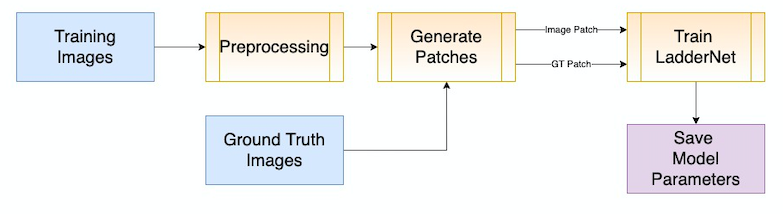

## Define parameters

In [50]:
# log file
if not os.path.exists('./logs'):
    os.mkdir('logs')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

start_epoch = 0  # start from epoch 0 or last checkpoint epoch
total_epoch = N_epochs

val_portion = 0.1

layers = 4
filters = 10

lr_epoch = np.array([150, total_epoch])
lr_value= np.array([0.001, 0.0001])

## Preprocess images

In [51]:
def group_images(data, per_row):
    """
    Arrange multiple images into rows and columns for visualization
    """
    assert data.shape[0]%per_row==0
    assert (data.shape[1]==1 or data.shape[1]==3)
    data = np.transpose(data,(0, 2, 3, 1))  #corect format for imshow
    all_stripe = []
    for i in range(int(data.shape[0]/per_row)):
        stripe = data[i * per_row]
        for k in range(i * per_row + 1, i * per_row+per_row):
            stripe = np.concatenate((stripe, data[k]), axis=1)
        all_stripe.append(stripe)
    totimg = all_stripe[0]
    for i in range(1, len(all_stripe)):
        totimg = np.concatenate((totimg, all_stripe[i]), axis=0)
    return totimg

def visualize_image(data):
    """
    Save the image as a PNG file
    """
    assert (len(data.shape)==3) #height*width*channels
    img = None
    if data.shape[2]==1:  #in case it is black and white
        data = np.reshape(data,(data.shape[0],data.shape[1]))
    if np.max(data)>1:
        img = Image.fromarray(data.astype(np.uint8))   #the image is already 0-255
    else:
        img = Image.fromarray((data*255).astype(np.uint8))  #the image is between 0-1
    return img


In [52]:
###################################################
#
#   Script to pre-process the original imgs
#
##################################################


import numpy as np
from PIL import Image
import cv2


# My pre processing (use for both training and testing!)
def pre_process(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    return train_imgs


#============================================================
#========= PRE PROCESSING FUNCTIONS ========================#
#============================================================

# # convert RGB image in black and white
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

#==== histogram equalization
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

#data consinstency check
def data_consistency_check(imgs,masks):
    assert(len(imgs.shape)==len(masks.shape))
    assert(imgs.shape[0]==masks.shape[0])
    assert(imgs.shape[2]==masks.shape[2])
    assert(imgs.shape[3]==masks.shape[3])
    assert(masks.shape[1]==1)
    assert(imgs.shape[1]==1 or imgs.shape[1]==3)



In [53]:
DRIVE_train_imgs_original = dataset_path + config.get('data paths', 'train_imgs_original')
DRIVE_train_groudTruth = dataset_path + config.get('data paths', 'train_groundTruth')
patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))
N_subimgs = int(config.get('training settings', 'N_subimgs'))
inside_FOV = config.getboolean('training settings', 'inside_FOV')

train_imgs_original = load_hdf5(DRIVE_train_imgs_original)
train_gt = load_hdf5(DRIVE_train_groudTruth) #masks always the same

train_imgs = pre_process(train_imgs_original)
train_gt = train_gt/255.

train_imgs = train_imgs[:,:,9:574,:]  #cut bottom and top so now it is 565*565
train_gt = train_gt[:,:,9:574,:]  #cut bottom and top so now it is 565*565
data_consistency_check(train_imgs, train_gt)




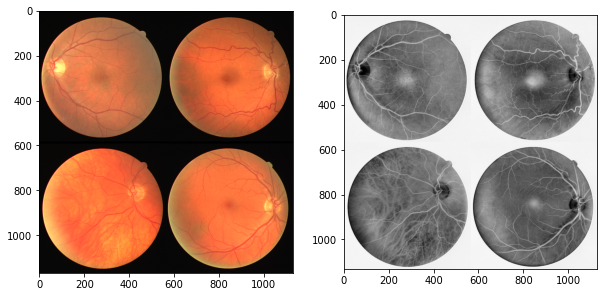

In [54]:
sample_original_images = visualize_image(group_images(train_imgs_original[0:4,:,:,:], 2))
sample_pre_processed_images = visualize_image(group_images(train_imgs[0:4,:,:,:], 2))

# plt.imshow(sample_original_images)
fig = plt.figure(figsize= (10,20))
ax = fig.add_subplot(1, 2, 1 )
ax.imshow(sample_original_images)
ax2 = fig.add_subplot(1, 2, 2 )
ax2.imshow(sample_pre_processed_images, cmap="Greys")
# ax3 = fig.add_subplot(1, 3, 3 )
# ax3.imshow(train_gt, cmap="Greys")

## Generate Patches from training images

In [55]:
# extract patches randomly in the full training images
#  -- Inside OR in full image
def extract_random(full_imgs, full_masks, patch_h, patch_w, N_patches, inside=True):
    if (N_patches%full_imgs.shape[0] != 0):
        print("N_patches: plase enter a multiple of 20")
        exit()
    assert (len(full_imgs.shape)==4 and len(full_masks.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    assert (full_masks.shape[1]==1)   #masks only black and white
    assert (full_imgs.shape[2] == full_masks.shape[2] and full_imgs.shape[3] == full_masks.shape[3])
    patches = np.empty((N_patches,full_imgs.shape[1],patch_h,patch_w))
    patches_masks = np.empty((N_patches,full_masks.shape[1],patch_h,patch_w))
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    # (0,0) in the center of the image
    patch_per_img = int(N_patches/full_imgs.shape[0])  #N_patches equally divided in the full images
    print("patches per full image: " +str(patch_per_img))
    iter_tot = 0   #iter over the total numbe rof patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        k=0
        while k <patch_per_img:
            x_center = random.randint(0+int(patch_w/2),img_w-int(patch_w/2))
            # print "x_center " +str(x_center)
            y_center = random.randint(0+int(patch_h/2),img_h-int(patch_h/2))
            # print "y_center " +str(y_center)
            #check whether the patch is fully contained in the FOV
            if inside==True:
                if is_patch_inside_FOV(x_center,y_center,img_w,img_h,patch_h)==False:
                    continue
            patch = full_imgs[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patch_mask = full_masks[i,:,y_center-int(patch_h/2):y_center+int(patch_h/2),x_center-int(patch_w/2):x_center+int(patch_w/2)]
            patches[iter_tot]=patch
            patches_masks[iter_tot]=patch_mask
            iter_tot +=1   #total
            k+=1  #per full_img
    return patches, patches_masks


In [56]:
print("\ntrain images/masks shape:")
print(train_imgs.shape)
print("train images range (min-max): " +str(np.min(train_imgs)) +' - '+str(np.max(train_imgs)))
print("train ground truth are within 0-1\n")

#extract the TRAINING patches from the full images
patches_imgs_train, patches_gt_train = extract_random(train_imgs, train_gt, patch_height, patch_width, N_subimgs, inside_FOV)
data_consistency_check(patches_imgs_train, patches_gt_train)

print("\ntrain PATCHES images/masks shape:")
print(patches_imgs_train.shape)
print("train PATCHES images range (min-max): " +str(np.min(patches_imgs_train)) +' - '+str(np.max(patches_imgs_train)))



train images/masks shape:
(20, 1, 565, 565)
train images range (min-max): 0.0 - 1.0
train ground truth are within 0-1

patches per full image: 95

train PATCHES images/masks shape:
(1900, 1, 48, 48)
train PATCHES images range (min-max): 0.0 - 1.0


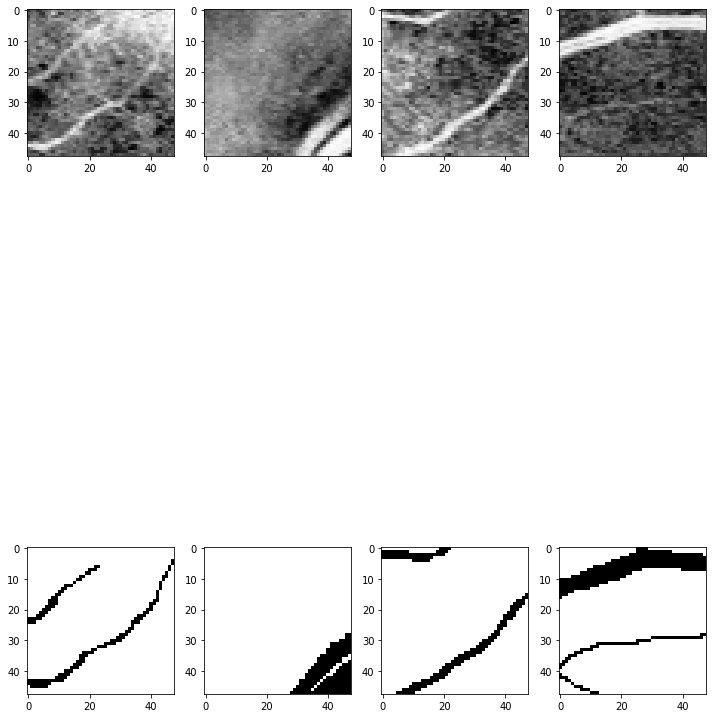

In [57]:
sample_patches_imgs_train = visualize_image(group_images(patches_imgs_train[0:4,:,:,:], 2))
np.squeeze(patches_imgs_train[0,:,:,:]).shape

fig = plt.figure(figsize= (10,20))
ax = fig.add_subplot(2, 4, 1 )
ax.imshow(np.squeeze(patches_imgs_train[0,:,:,:]), cmap="Greys")
ax = fig.add_subplot(2, 4, 2 )
ax.imshow(np.squeeze(patches_imgs_train[1,:,:,:]), cmap="Greys")
ax = fig.add_subplot(2, 4, 3 )
ax.imshow(np.squeeze(patches_imgs_train[2,:,:,:]), cmap="Greys")
ax = fig.add_subplot(2, 4, 4 )
ax.imshow(np.squeeze(patches_imgs_train[3,:,:,:]), cmap="Greys")

ax = fig.add_subplot(2, 4, 5 )
ax.imshow(np.squeeze(patches_gt_train[0,:,:,:]), cmap="Greys")
ax = fig.add_subplot(2, 4, 6 )
ax.imshow(np.squeeze(patches_gt_train[1,:,:,:]), cmap="Greys")
ax = fig.add_subplot(2, 4, 7 )
ax.imshow(np.squeeze(patches_gt_train[2,:,:,:]), cmap="Greys")
ax = fig.add_subplot(2, 4, 8 )
ax.imshow(np.squeeze(patches_gt_train[3,:,:,:]), cmap="Greys")
fig.tight_layout()



## Build the network

In [58]:
def count_parameters(model):
    """
    Count number of trainable parameters in the netowrk
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

drop = 0.25
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)

class BasicBlock(nn.Module):
    """
    Implements Shared weight residual block
    """
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        if inplanes!= planes:
            self.conv0 = conv3x3(inplanes,planes)

        self.inplanes = inplanes
        self.planes = planes

        self.conv1 = conv3x3(planes, planes, stride)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        #self.conv2 = conv3x3(planes, planes)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.drop = nn.Dropout2d(p=drop)

    def forward(self, x):
        if self.inplanes != self.planes:
            x = self.conv0(x)
            x = F.relu(x)

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.drop(out)

        out1 = self.conv1(out)
        #out1 = self.relu(out1)

        out2 = out1 + x

        return F.relu(out2)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Initial_LadderBlock(nn.Module):

    def __init__(self, planes, layers, kernel=3, block=BasicBlock, inplanes = 3):
        super().__init__()
        self.planes = planes
        self.layers = layers
        self.kernel = kernel

        self.padding = int((kernel-1)/2)
        self.inconv = nn.Conv2d(in_channels=inplanes,out_channels=planes,
                                kernel_size=3,stride=1,padding=1,bias=True)

        # create module list for down branch
        self.down_module_list = nn.ModuleList()
        for i in range(0, layers):
            self.down_module_list.append(block(planes*(2**i), planes*(2**i)))

        # use strided conv instead of poooling
        self.down_conv_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_conv_list.append(nn.Conv2d(planes*2**i,
                                                 planes*2**(i+1),
                                                 stride=2,
                                                 kernel_size=kernel,
                                                 padding=self.padding))

        # create module for bottom block
        self.bottom = block(planes*(2**layers),
                            planes*(2**layers))

        # create module list for up branch
        self.up_conv_list = nn.ModuleList()
        self.up_dense_list = nn.ModuleList()
        for i in range(0, layers):
            self.up_conv_list.append(nn.ConvTranspose2d(in_channels=planes*2**(layers-i),
                                                        out_channels=planes*2**max(0,layers-i-1),
                                                        kernel_size=3,
                                                        stride=2,
                                                        padding=1,
                                                        output_padding=1,
                                                        bias=True)
                                     )
            self.up_dense_list.append(block(planes*2**max(0,layers-i-1), 
                                            planes*2**max(0,layers-i-1)))


    def forward(self, x):
        out = self.inconv(x)
        out = F.relu(out)

        down_out = []
        # down branch
        for i in range(0, self.layers):
            out = self.down_module_list[i](out)
            down_out.append(out)
            out = self.down_conv_list[i](out)
            out = F.relu(out)

        # bottom branch
        out = self.bottom(out)
        bottom = out

        # up branch
        up_out = []
        up_out.append(bottom)

        for j in range(0, self.layers):
            out = self.up_conv_list[j](out) + down_out[self.layers-j-1]
            #out = F.relu(out)
            out = self.up_dense_list[j](out)
            up_out.append(out)

        return up_out

class LadderBlock(nn.Module):
    def __init__(self,planes,layers,kernel=3,block=BasicBlock,inplanes = 3):
        super().__init__()
        self.planes = planes
        self.layers = layers
        self.kernel = kernel

        self.padding = int((kernel-1)/2)
        self.inconv = block(planes,planes)

        # create module list for down branch
        self.down_module_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_module_list.append(block(planes*(2**i),planes*(2**i)))

        # use strided conv instead of poooling
        self.down_conv_list = nn.ModuleList()
        for i in range(0,layers):
            self.down_conv_list.append(nn.Conv2d(planes*2**i,planes*2**(i+1),stride=2,kernel_size=kernel,padding=self.padding))

        # create module for bottom block
        self.bottom = block(planes*(2**layers),planes*(2**layers))

        # create module list for up branch
        self.up_conv_list = nn.ModuleList()
        self.up_dense_list = nn.ModuleList()
        for i in range(0, layers):
            self.up_conv_list.append(nn.ConvTranspose2d(planes*2**(layers-i), planes*2**max(0,layers-i-1), kernel_size=3,
                                                        stride=2,padding=1,output_padding=1,bias=True))
            self.up_dense_list.append(block(planes*2**max(0,layers-i-1),planes*2**max(0,layers-i-1)))

    def forward(self, x):
        out = self.inconv(x[-1])

        down_out = []
        # down branch
        for i in range(0,self.layers):
            out = out + x[-i-1]
            out = self.down_module_list[i](out)
            down_out.append(out)

            out = self.down_conv_list[i](out)
            out = F.relu(out)

        # bottom branch
        out = self.bottom(out)
        bottom = out

        # up branch
        up_out = []
        up_out.append(bottom)

        for j in range(0,self.layers):
            out = self.up_conv_list[j](out) + down_out[self.layers-j-1]
            #out = F.relu(out)
            out = self.up_dense_list[j](out)
            up_out.append(out)

        return up_out

class Final_LadderBlock(nn.Module):

    def __init__(self,planes,layers,kernel=3,block=BasicBlock,inplanes = 3):
        super().__init__()
        self.block = LadderBlock(planes,layers,kernel=kernel,block=block)

    def forward(self, x):
        out = self.block(x)
        return out[-1]

class LadderNetv6(nn.Module):
    def __init__(self,layers=3,filters=16,num_classes=2,inplanes=3):
        super().__init__()
        self.initial_block = Initial_LadderBlock(planes=filters,layers=layers,inplanes=inplanes)
        #self.middle_block = LadderBlock(planes=filters,layers=layers)
        self.final_block = Final_LadderBlock(planes=filters,layers=layers)
        self.final = nn.Conv2d(in_channels=filters,out_channels=num_classes,kernel_size=1)

    def forward(self,x):
        out = self.initial_block(x)
        #out = self.middle_block(out)
        out = self.final_block(out)
        out = self.final(out)
        #out = F.relu(out)
        out = F.log_softmax(out,dim=1)
        return out

## Loss function

$loss = - (1-w_j)w_c\sum_{n \in B_1} log(\hat{p_n}) - w_j log(\frac{intersection}{union}) $

Where 

$B_1$ is the set of indices of samples with label as 1 (i.e indices of blood vesses pixels),

$w_j$ is the Jaccard weight and 

$w_c$ is the weight for positive samples which is  set as the fraction of non-blood vessel pixels to that of blood vessel pixels

In [59]:
class LossMulti:
    def __init__(self, jaccard_weight=0, class_weights=None, num_classes=1):
        if class_weights is not None:
            nll_weight = cuda(
                torch.from_numpy(class_weights.astype(np.float32)))
        else:
            nll_weight = None
        self.nll_loss = nn.NLLLoss2d(weight=nll_weight)
        self.jaccard_weight = jaccard_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)
        if self.jaccard_weight:
            eps = 1e-15
            for cls in range(self.num_classes):
                jaccard_target = (targets == cls).float()
                jaccard_output = outputs[:, cls].exp()
                intersection = (jaccard_output * jaccard_target).sum()

                union = jaccard_output.sum() + jaccard_target.sum()
                loss -= torch.log((intersection + eps) / (union - intersection + eps)) * self.jaccard_weight
        return loss

In [60]:
net = LadderNetv6(num_classes=2, layers=layers, filters=filters, inplanes=1)
print("Toral number of parameters: "+str(count_parameters(net)))
check_path = 'LadderNetv65_layer_%d_filter_%d.pt7'% (layers, filters) #'UNet16.pt7'#'UNet_Resnet101.pt7'
resume = False

#criterion = torch.nn.NLLLoss2d()
criterion = LossMulti(jaccard_weight=0.2)
#criterion = CrossEntropy2d()

#optimizer = optim.SGD(net.parameters(),
#                     lr=lr_schedule[0], momentum=0.9, weight_decay=5e-4, nesterov=True)
optimizer = optim.Adam(net.parameters(),lr=0.001)

Toral number of parameters: 1381652


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


## Define Dataset class

In [61]:
class TrainDataset(Dataset):
    """Endovis 2018 dataset."""

    def __init__(self, patches_imgs, patches_masks_train):
        self.imgs = patches_imgs
        self.masks = patches_masks_train

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        tmp = self.masks[idx]
        tmp = np.squeeze(tmp,0)
        return torch.from_numpy(self.imgs[idx,...]).float(), torch.from_numpy(tmp).long()

val_ind = random.sample(range(patches_gt_train.shape[0]), 
                        int(np.floor(val_portion*patches_gt_train.shape[0])))

train_ind =  set(range(patches_gt_train.shape[0])) - set(val_ind)
train_ind = list(train_ind)

train_set = TrainDataset(patches_imgs_train[train_ind,...],
                         patches_gt_train[train_ind,...])

train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)

val_set = TrainDataset(patches_imgs_train[val_ind,...], 
                       patches_gt_train[val_ind,...])
val_loader = DataLoader(val_set, batch_size=batch_size,
                          shuffle=True, num_workers=4)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Define functions for train and evaluate

In [62]:
best_loss = np.Inf

# create a list of learning rate with epochs
lr_schedule = np.zeros(total_epoch)
for l in range(len(lr_epoch)):
    if l ==0:
        lr_schedule[0:lr_epoch[l]] = lr_value[l]
    else:
        lr_schedule[lr_epoch[l-1]:lr_epoch[l]] = lr_value[l]

if device == 'cuda':
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+check_path)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    IoU = []

        # get learning rate from learing schedule
    lr = lr_schedule[epoch]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    print("Learning rate = %4f\n" % lr)


    IU = []
    # train network
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print("Epoch %d: Train loss %4f\n" % (epoch, train_loss / np.float32(len(train_loader))))
    return train_loss / np.float32(len(train_loader))

In [63]:
def validate(epoch, display=False):
    global best_loss
    net.eval()
    test_loss = 0
    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

        print(
            'Valid loss: {:.4f}'.format(test_loss))
    # Save checkpoint.
    if test_loss < best_loss:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'best_loss': best_loss,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + check_path)
        best_loss = test_loss
    return test_loss/np.float32(len(val_loader))

## Start training

In [130]:
from tqdm import tqdm

train_losses = []
test_losses = []
for epoch in range(start_epoch, total_epoch):
    train_loss = train(epoch)
    test_loss = validate(epoch, False)
    train_losses.append(train_loss)
    test_losses.append(test_loss)


  0%|          | 0/27 [00:00<?, ?it/s]


Epoch: 0
Learning rate = 0.001000



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 27/27 [00:01<00:00, 14.42it/s]

Epoch 0: Train loss 0.360627



Valid loss: 0.8644
Saving..


  0%|          | 0/27 [00:00<?, ?it/s]


Epoch: 1
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.54it/s]

Epoch 1: Train loss 0.282285




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8165
Saving..

Epoch: 2
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.82it/s]

Epoch 2: Train loss 0.273586




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7998
Saving..

Epoch: 3
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.87it/s]

Epoch 3: Train loss 0.260978




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7264
Saving..

Epoch: 4
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.81it/s]

Epoch 4: Train loss 0.223379




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5780
Saving..

Epoch: 5
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.88it/s]

Epoch 5: Train loss 0.183645




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4887
Saving..

Epoch: 6
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.92it/s]

Epoch 6: Train loss 0.160241




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4448
Saving..

Epoch: 7
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.87it/s]

Epoch 7: Train loss 0.146985




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4240
Saving..

Epoch: 8
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.66it/s]

Epoch 8: Train loss 0.138436




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4142
Saving..

Epoch: 9
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.84it/s]

Epoch 9: Train loss 0.134481




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4019
Saving..

Epoch: 10
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.66it/s]

Epoch 10: Train loss 0.129456




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4007
Saving..

Epoch: 11
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.74it/s]

Epoch 11: Train loss 0.126227




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3912
Saving..

Epoch: 12
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.74it/s]

Epoch 12: Train loss 0.124054




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3918

Epoch: 13
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.86it/s]

Epoch 13: Train loss 0.120908




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3901
Saving..

Epoch: 14
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.71it/s]

Epoch 14: Train loss 0.114475




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3820
Saving..

Epoch: 15
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.68it/s]

Epoch 15: Train loss 0.112122




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3755
Saving..

Epoch: 16
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.85it/s]

Epoch 16: Train loss 0.108021




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3758

Epoch: 17
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.77it/s]

Epoch 17: Train loss 0.107225




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3755
Saving..

Epoch: 18
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.78it/s]

Epoch 18: Train loss 0.102726




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3876

Epoch: 19
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.87it/s]

Epoch 19: Train loss 0.098845




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3839

Epoch: 20
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.74it/s]

Epoch 20: Train loss 0.097092




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3857

Epoch: 21
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.78it/s]

Epoch 21: Train loss 0.093754




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3783

Epoch: 22
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.51it/s]

Epoch 22: Train loss 0.092480




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3761

Epoch: 23
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.57it/s]

Epoch 23: Train loss 0.088809




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3923

Epoch: 24
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.64it/s]

Epoch 24: Train loss 0.086922




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3879

Epoch: 25
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.63it/s]

Epoch 25: Train loss 0.084170




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.3980

Epoch: 26
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.76it/s]

Epoch 26: Train loss 0.081680




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4075

Epoch: 27
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.76it/s]

Epoch 27: Train loss 0.079399




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4032

Epoch: 28
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.67it/s]

Epoch 28: Train loss 0.077560




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4070

Epoch: 29
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.71it/s]

Epoch 29: Train loss 0.075937




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4341

Epoch: 30
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.49it/s]

Epoch 30: Train loss 0.075031




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4209

Epoch: 31
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.65it/s]

Epoch 31: Train loss 0.072945




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4294

Epoch: 32
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.55it/s]

Epoch 32: Train loss 0.070661




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4216

Epoch: 33
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.73it/s]

Epoch 33: Train loss 0.069300




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4427

Epoch: 34
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.55it/s]

Epoch 34: Train loss 0.067662




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4650

Epoch: 35
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.60it/s]

Epoch 35: Train loss 0.065829




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4464

Epoch: 36
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.39it/s]

Epoch 36: Train loss 0.065112




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4405

Epoch: 37
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.57it/s]

Epoch 37: Train loss 0.063943




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4521

Epoch: 38
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.49it/s]

Epoch 38: Train loss 0.062798




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4557

Epoch: 39
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.49it/s]

Epoch 39: Train loss 0.061141




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4696

Epoch: 40
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.64it/s]

Epoch 40: Train loss 0.060026




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4994

Epoch: 41
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.56it/s]

Epoch 41: Train loss 0.059220




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4929

Epoch: 42
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.26it/s]

Epoch 42: Train loss 0.057923




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4931

Epoch: 43
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.31it/s]

Epoch 43: Train loss 0.056854




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4798

Epoch: 44
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.27it/s]

Epoch 44: Train loss 0.056541




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4741

Epoch: 45
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.27it/s]

Epoch 45: Train loss 0.055438




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4846

Epoch: 46
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.35it/s]

Epoch 46: Train loss 0.053881




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4921

Epoch: 47
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.36it/s]

Epoch 47: Train loss 0.053195




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4986

Epoch: 48
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.48it/s]

Epoch 48: Train loss 0.052547




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5124

Epoch: 49
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.16it/s]

Epoch 49: Train loss 0.051926




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5223

Epoch: 50
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.21it/s]

Epoch 50: Train loss 0.051173




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.4994

Epoch: 51
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.32it/s]

Epoch 51: Train loss 0.050749




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5418

Epoch: 52
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.30it/s]

Epoch 52: Train loss 0.050611




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5533

Epoch: 53
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.32it/s]

Epoch 53: Train loss 0.049726




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5195

Epoch: 54
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.99it/s]

Epoch 54: Train loss 0.048415




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5225

Epoch: 55
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.40it/s]

Epoch 55: Train loss 0.047737




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5588

Epoch: 56
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.36it/s]

Epoch 56: Train loss 0.047274




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5553

Epoch: 57
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.17it/s]

Epoch 57: Train loss 0.047052




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5553

Epoch: 58
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.22it/s]

Epoch 58: Train loss 0.046534




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5561

Epoch: 59
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.20it/s]

Epoch 59: Train loss 0.045614




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5502

Epoch: 60
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.17it/s]

Epoch 60: Train loss 0.045412




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5282

Epoch: 61
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.13it/s]

Epoch 61: Train loss 0.046015




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5626

Epoch: 62
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.94it/s]

Epoch 62: Train loss 0.044689




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5528

Epoch: 63
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.03it/s]

Epoch 63: Train loss 0.044004




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5562

Epoch: 64
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.12it/s]

Epoch 64: Train loss 0.043035




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5774

Epoch: 65
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.03it/s]

Epoch 65: Train loss 0.042416




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5783

Epoch: 66
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.01it/s]

Epoch 66: Train loss 0.041702




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5842

Epoch: 67
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.98it/s]

Epoch 67: Train loss 0.041432




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6163

Epoch: 68
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.82it/s]

Epoch 68: Train loss 0.040925




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5992

Epoch: 69
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.85it/s]

Epoch 69: Train loss 0.040725




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6190

Epoch: 70
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.06it/s]

Epoch 70: Train loss 0.040234




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.5959

Epoch: 71
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.71it/s]

Epoch 71: Train loss 0.040047




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6102

Epoch: 72
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.93it/s]

Epoch 72: Train loss 0.039482




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6304

Epoch: 73
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.79it/s]

Epoch 73: Train loss 0.039172




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6098

Epoch: 74
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.99it/s]

Epoch 74: Train loss 0.038659




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6429

Epoch: 75
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.92it/s]

Epoch 75: Train loss 0.038361




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6533

Epoch: 76
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.98it/s]

Epoch 76: Train loss 0.038302




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6497

Epoch: 77
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.06it/s]

Epoch 77: Train loss 0.037742




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6109

Epoch: 78
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.91it/s]

Epoch 78: Train loss 0.037981




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6706

Epoch: 79
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.93it/s]

Epoch 79: Train loss 0.037587




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6804

Epoch: 80
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.04it/s]

Epoch 80: Train loss 0.037691




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6474

Epoch: 81
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.91it/s]

Epoch 81: Train loss 0.036998




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6442

Epoch: 82
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.86it/s]

Epoch 82: Train loss 0.036372




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6533

Epoch: 83
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.66it/s]

Epoch 83: Train loss 0.035985




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6649

Epoch: 84
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.96it/s]

Epoch 84: Train loss 0.035702




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6554

Epoch: 85
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.92it/s]

Epoch 85: Train loss 0.035279




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6682

Epoch: 86
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.96it/s]

Epoch 86: Train loss 0.034985




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6592

Epoch: 87
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.76it/s]

Epoch 87: Train loss 0.034434




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6873

Epoch: 88
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.03it/s]

Epoch 88: Train loss 0.034340




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7186

Epoch: 89
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.07it/s]

Epoch 89: Train loss 0.034204




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7063

Epoch: 90
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.09it/s]

Epoch 90: Train loss 0.033869




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6552

Epoch: 91
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.16it/s]

Epoch 91: Train loss 0.034013




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7137

Epoch: 92
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.03it/s]

Epoch 92: Train loss 0.033491




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7308

Epoch: 93
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.13it/s]

Epoch 93: Train loss 0.033187




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6818

Epoch: 94
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.11it/s]

Epoch 94: Train loss 0.032819




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7064

Epoch: 95
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.00it/s]

Epoch 95: Train loss 0.032860




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6592

Epoch: 96
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.13it/s]

Epoch 96: Train loss 0.032757




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7134

Epoch: 97
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.12it/s]

Epoch 97: Train loss 0.032195




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6997

Epoch: 98
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.11it/s]

Epoch 98: Train loss 0.031772




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7367

Epoch: 99
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.06it/s]

Epoch 99: Train loss 0.031733




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6677

Epoch: 100
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.10it/s]

Epoch 100: Train loss 0.032185




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7381

Epoch: 101
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.20it/s]

Epoch 101: Train loss 0.031660




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7314

Epoch: 102
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.22it/s]

Epoch 102: Train loss 0.031415




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7250

Epoch: 103
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.03it/s]

Epoch 103: Train loss 0.031115




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7058

Epoch: 104
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.20it/s]

Epoch 104: Train loss 0.030596




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7593

Epoch: 105
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.19it/s]

Epoch 105: Train loss 0.031074




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.6988

Epoch: 106
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.07it/s]

Epoch 106: Train loss 0.030881




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7326

Epoch: 107
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.95it/s]

Epoch 107: Train loss 0.030846




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7148

Epoch: 108
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.16it/s]

Epoch 108: Train loss 0.030437




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7261

Epoch: 109
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.89it/s]

Epoch 109: Train loss 0.030030




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7015

Epoch: 110
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.02it/s]

Epoch 110: Train loss 0.029720




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7223

Epoch: 111
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.22it/s]

Epoch 111: Train loss 0.029191




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7292

Epoch: 112
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.87it/s]

Epoch 112: Train loss 0.028900




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7861

Epoch: 113
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.13it/s]

Epoch 113: Train loss 0.028678




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7349

Epoch: 114
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.89it/s]

Epoch 114: Train loss 0.029114




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7249

Epoch: 115
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.06it/s]

Epoch 115: Train loss 0.029062




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7684

Epoch: 116
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.18it/s]

Epoch 116: Train loss 0.028268




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7594

Epoch: 117
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.86it/s]

Epoch 117: Train loss 0.028421




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7522

Epoch: 118
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.04it/s]

Epoch 118: Train loss 0.027732




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8179

Epoch: 119
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.10it/s]

Epoch 119: Train loss 0.027684




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7462

Epoch: 120
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.10it/s]

Epoch 120: Train loss 0.027491




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7592

Epoch: 121
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.20it/s]

Epoch 121: Train loss 0.027238




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7836

Epoch: 122
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.18it/s]

Epoch 122: Train loss 0.026859




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8041

Epoch: 123
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.81it/s]

Epoch 123: Train loss 0.026859




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7875

Epoch: 124
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.84it/s]

Epoch 124: Train loss 0.027013




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7777

Epoch: 125
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.89it/s]

Epoch 125: Train loss 0.026727




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7377

Epoch: 126
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.95it/s]

Epoch 126: Train loss 0.026614




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8077

Epoch: 127
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.83it/s]

Epoch 127: Train loss 0.026977




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7675

Epoch: 128
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.94it/s]

Epoch 128: Train loss 0.026281




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8402

Epoch: 129
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.88it/s]

Epoch 129: Train loss 0.026447




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8297

Epoch: 130
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.77it/s]

Epoch 130: Train loss 0.026158




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7900

Epoch: 131
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.65it/s]

Epoch 131: Train loss 0.026014




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8275

Epoch: 132
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.70it/s]

Epoch 132: Train loss 0.025795




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8239

Epoch: 133
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.76it/s]

Epoch 133: Train loss 0.025788




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8294

Epoch: 134
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.72it/s]

Epoch 134: Train loss 0.025290




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.7885

Epoch: 135
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.78it/s]

Epoch 135: Train loss 0.025273




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8213

Epoch: 136
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.95it/s]

Epoch 136: Train loss 0.024675




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8566

Epoch: 137
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.05it/s]

Epoch 137: Train loss 0.024427




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8499

Epoch: 138
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 19.19it/s]

Epoch 138: Train loss 0.024379




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8707

Epoch: 139
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.86it/s]

Epoch 139: Train loss 0.024259




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8790

Epoch: 140
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.92it/s]

Epoch 140: Train loss 0.024236




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8635

Epoch: 141
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.98it/s]

Epoch 141: Train loss 0.024659




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8230

Epoch: 142
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.93it/s]

Epoch 142: Train loss 0.024379




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8555

Epoch: 143
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.88it/s]

Epoch 143: Train loss 0.024196




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8690

Epoch: 144
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.82it/s]

Epoch 144: Train loss 0.024438




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8347

Epoch: 145
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.84it/s]

Epoch 145: Train loss 0.023837




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8546

Epoch: 146
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.89it/s]

Epoch 146: Train loss 0.023607




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8979

Epoch: 147
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.84it/s]

Epoch 147: Train loss 0.023492




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8620

Epoch: 148
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.68it/s]

Epoch 148: Train loss 0.023617




  0%|          | 0/27 [00:00<?, ?it/s]

Valid loss: 0.8448

Epoch: 149
Learning rate = 0.001000



100%|██████████| 27/27 [00:01<00:00, 18.77it/s]

Epoch 149: Train loss 0.023197



Valid loss: 0.8786


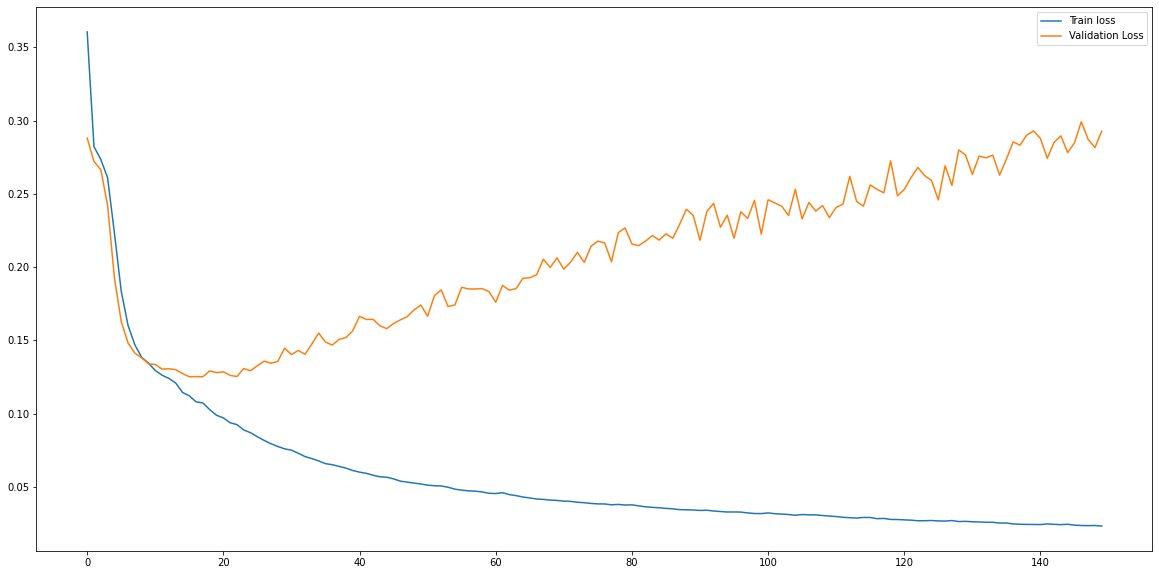

In [132]:
plt.figure(figsize=(20,10))
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["Train loss", "Validation Loss"])

# 8. Run Prediction on test images and compute the metrics
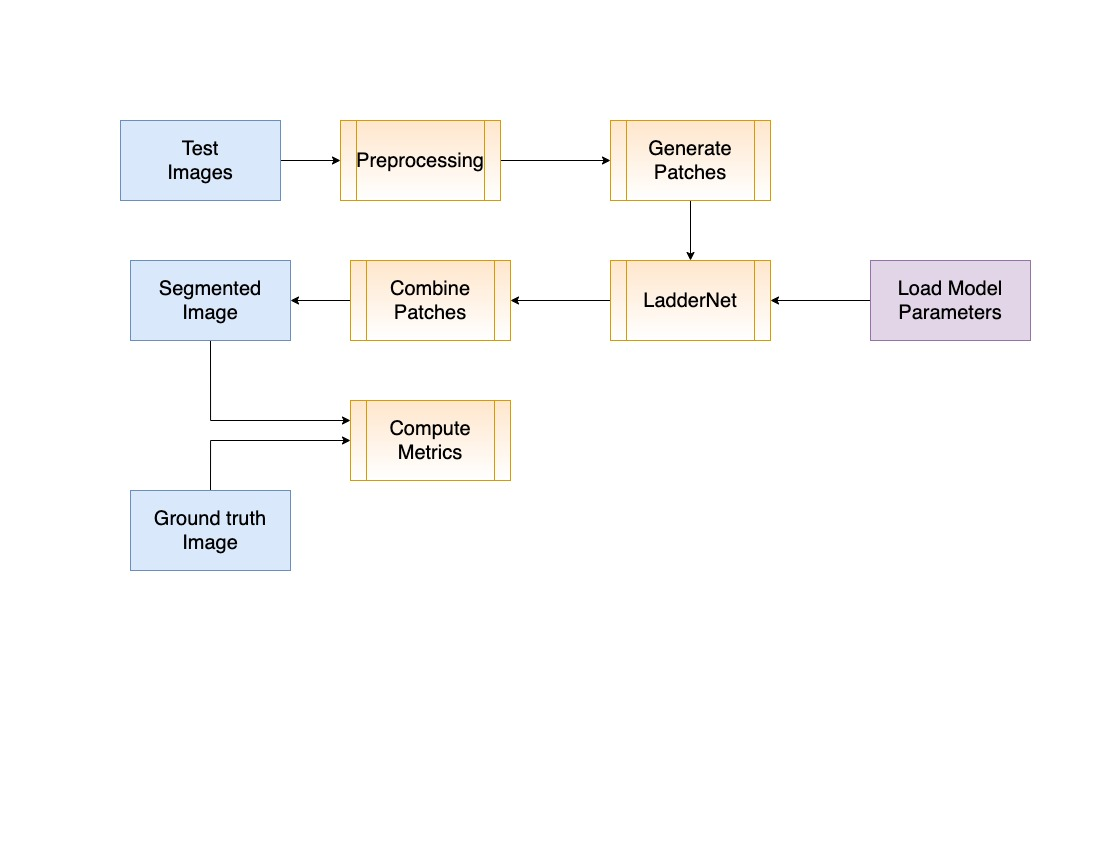




## Set configuration variables for running inference

In [64]:
# original test images (for FOV selection)
DRIVE_test_imgs_original = root_path + "DRIVE_datasets_training_testing/" +config.get('data paths', 'test_imgs_original')
test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]

# the border masks provided by the DRIVE
DRIVE_test_border_masks = dataset_path + config.get('data paths', 'test_border_masks')
test_border_masks = load_hdf5(DRIVE_test_border_masks)

# the stride in case output with average
stride_height = int(config.get('testing settings', 'stride_height'))
stride_width = int(config.get('testing settings', 'stride_width'))
assert (stride_height < patch_height and stride_width < patch_width)

path_experiment = root_path  + name_experiment  + '/'
# N full images to be predicted
Imgs_to_test = int(config.get('testing settings', 'full_images_to_test'))
# ====== average mode ===========
average_mode = config.getboolean('testing settings', 'average_mode')

# Grouping of the predicted images for visualization
N_visual = int(config.get('testing settings', 'N_group_visual'))

## Define functions to generate test data

In [65]:
# Divide all the full_imgs in pacthes
def extract_ordered(full_imgs, patch_h, patch_w):
    assert (len(full_imgs.shape)==4)  #4D arrays
    assert (full_imgs.shape[1]==1 or full_imgs.shape[1]==3)  #check the channel is 1 or 3
    img_h = full_imgs.shape[2]  #height of the full image
    img_w = full_imgs.shape[3] #width of the full image
    N_patches_h = int(img_h/patch_h) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_h) +" patches in height, with about " +str(img_h%patch_h) +" pixels left over")
    N_patches_w = int(img_w/patch_w) #round to lowest int
    if (img_h%patch_h != 0):
        print("warning: " +str(N_patches_w) +" patches in width, with about " +str(img_w%patch_w) +" pixels left over")
    print("number of patches per image: " +str(N_patches_h*N_patches_w))
    N_patches_tot = (N_patches_h*N_patches_w)*full_imgs.shape[0]
    patches = np.empty((N_patches_tot,full_imgs.shape[1],patch_h,patch_w))

    iter_tot = 0   #iter over the total number of patches (N_patches)
    for i in range(full_imgs.shape[0]):  #loop over the full images
        for h in range(N_patches_h):
            for w in range(N_patches_w):
                patch = full_imgs[i,:,h*patch_h:(h*patch_h)+patch_h, w * patch_w:(w*patch_w)+patch_w]
                patches[iter_tot]=patch
                iter_tot +=1   #total
    assert (iter_tot==N_patches_tot)
    return patches  #array with all the full_imgs divided in patches

# Extend the full images becasue patch divison is not exact
def paint_border(data,patch_h,patch_w):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    img_h=data.shape[2]
    img_w=data.shape[3]
    if (img_h%patch_h)==0:
        new_img_h = img_h
    else:
        new_img_h = ((int(img_h)/int(patch_h))+1)*patch_h
    if (img_w%patch_w)==0:
        new_img_w = img_w
    else:
        new_img_w = ((int(img_w)/int(patch_w))+1)*patch_w
    new_data = np.zeros((data.shape[0], data.shape[1], int(new_img_h), int(new_img_w)))
    new_data[:,:,0:img_h,0:img_w] = data[:,:,:,:]
    return new_data

# Load the original data and return the extracted patches for testing
def get_data_testing(DRIVE_test_imgs_original, DRIVE_test_groudTruth, Imgs_to_test, patch_height, patch_width):
    """
    Load the original test images and ground truth, extract patches  and return the extracted patches for testing
    :param DRIVE_test_imgs_original: 
    :param DRIVE_test_groudTruth: 
    :param Imgs_to_test: 
    :param patch_height: 
    :param patch_width: 
    :return: 
    """

    test_imgs_original = load_hdf5(DRIVE_test_imgs_original)
    gt_images = load_hdf5(DRIVE_test_groudTruth)

    test_imgs = pre_process(test_imgs_original)
    gt_images = gt_images / 255.

    # extend both images and masks so they can be divided exactly by the patches dimensions
    test_imgs = test_imgs[0:Imgs_to_test, :, :, :]
    gt_images = gt_images[0:Imgs_to_test, :, :, :]
    test_imgs = paint_border(test_imgs, patch_height, patch_width)
    gt_images = paint_border(gt_images, patch_height, patch_width)

    data_consistency_check(test_imgs, gt_images)

    # check masks are within 0-1
    assert (np.max(gt_images) == 1 and np.min(gt_images) == 0)

    print("\ntest images/masks shape:")
    print(test_imgs.shape)
    print("test images range (min-max): " + str(np.min(test_imgs)) + ' - ' + str(np.max(test_imgs)))
    print("test masks are within 0-1\n")

    # extract the TEST patches from the full images
    patches_imgs_test = extract_ordered(test_imgs, patch_height, patch_width)
    patches_masks_test = extract_ordered(gt_images, patch_height, patch_width)
    data_consistency_check(patches_imgs_test, patches_masks_test)

    print("\ntest PATCHES images/masks shape:")
    print(patches_imgs_test.shape)
    print("test PATCHES images range (min-max): " + str(np.min(patches_imgs_test)) + ' - ' + str(
        np.max(patches_imgs_test)))

    return patches_imgs_test, patches_masks_test


## Load the test data and divide into patches

In [66]:
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_gt_test = None
if average_mode:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = dataset_path + config.get('data paths', 'test_groundTruth'),  
        Imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),
        patch_height = patch_height,
        patch_width = patch_width,
        stride_height = stride_height,
        stride_width = stride_width
    )
else:
    patches_imgs_test, patches_gt_test = get_data_testing(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,
        DRIVE_test_groudTruth = dataset_path + config.get('data paths', 'test_groundTruth'),
        Imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),
        patch_height = patch_height,
        patch_width = patch_width,
    )


test images/masks shape:
(20, 1, 632, 613)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

number of patches per image: 156
number of patches per image: 156

test PATCHES images/masks shape:
(3120, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0


## Run the prediction for the patches


In [67]:
best_last = config.get('testing settings', 'best_last')

layers= 4
filters = 10
check_path = 'LadderNetv65_layer_%d_filter_%d.pt7'% (layers, filters) #'UNet16.pt7'#'UNet_Resnet101.pt7'
net = LadderNetv6(num_classes=2, layers=layers, filters=filters, inplanes=1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resume = True

if device == 'cuda':
    net.cuda()
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+check_path)
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']

class TrainDataset(Dataset):
    """Endovis 2018 dataset."""

    def __init__(self, patches_imgs):
        self.imgs = patches_imgs

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.imgs[idx,...]).float()

test_set = TrainDataset(patches_imgs_test)
test_loader = DataLoader(test_set, batch_size=batch_size,
                          shuffle=False, num_workers=4)

preds = []
for batch_idx, inputs in enumerate((test_loader)):
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = torch.nn.functional.softmax(outputs,dim=1)
    outputs = outputs.permute(0, 2, 3, 1)
    shape = list(outputs.shape)
    outputs = outputs.view(-1,shape[1]*shape[2], 2)

    outputs = outputs.data.cpu().numpy()
    preds.append(outputs)

predictions = np.concatenate(preds,axis=0)
print("Predictions finished")


==> Resuming from checkpoint..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predictions finished


## Convert the predicted arrays to corresponding image patches


In [68]:
def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    """
    Convert predictions from neural network to image

    """
    assert (len(pred.shape)==3)  #3D array: (Npatches,height*width,2)
    assert (pred.shape[2]==2 )  #check the classes are 2
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  #(Npatches,height*width)
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1]
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i, pix]=1
                else:
                    pred_images[i, pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images


In [69]:
# ===== Convert the prediction arrays in corresponding images
print(f"Shape of predictions from Laddernet  {predictions.shape}")
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")
print(f"Shape of predicted images {pred_patches.shape}")


Shape of predictions from Laddernet  (3120, 2304, 2)
Shape of predicted images (3120, 1, 48, 48)


## Tile the patches to create full image

In [70]:
def tile_patches(data,N_h,N_w):
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    assert(len(data.shape)==4)
    N_pacth_per_img = N_w*N_h
    assert(data.shape[0]%N_pacth_per_img == 0)
    N_full_imgs = data.shape[0]/N_pacth_per_img
    patch_h = data.shape[2]
    patch_w = data.shape[3]
    N_pacth_per_img = N_w*N_h
    # define and start full recompone
    full_recomp = np.empty((int(N_full_imgs),data.shape[1], int(N_h*patch_h), int(N_w*patch_w)) )
    k = 0  # iter full img
    s = 0  # iter single patch
    while (s<data.shape[0]):
        #recompone one:
        single_recon = np.empty((data.shape[1],N_h*patch_h,N_w*patch_w))
        for h in range(N_h):
            for w in range(N_w):
                single_recon[:,h*patch_h:(h*patch_h)+patch_h, w*patch_w:(w*patch_w)+patch_w]=data[s]
                s+=1
        full_recomp[k]=single_recon
        k+=1
    assert (k==N_full_imgs)
    return full_recomp

In [71]:
# function to set to black everything outside the FOV, in a full image
def kill_border(data, original_imgs_border_masks):
    assert (len(data.shape)==4)  #4D arrays
    assert (data.shape[1]==1 or data.shape[1]==3)  #check the channel is 1 or 3
    height = data.shape[2]
    width = data.shape[3]
    for i in range(data.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==False:
                    data[i,:,y,x]=0.0

def inside_FOV_DRIVE(i, x, y, DRIVE_masks):
    assert (len(DRIVE_masks.shape)==4)  #4D arrays
    assert (DRIVE_masks.shape[1]==1)  #DRIVE masks is black and white
    # DRIVE_masks = DRIVE_masks/255.  #NOOO!! otherwise with float numbers takes forever!!

    if (x >= DRIVE_masks.shape[3] or y >= DRIVE_masks.shape[2]): #my image bigger than the original
        return False

    if (DRIVE_masks[i,0,y,x]>0):  #0==black pixels
        # print DRIVE_masks[i,0,y,x]  #verify it is working right
        return True
    else:
        return False

In [72]:
# return only the pixels contained in the FOV, for both images and masks
def pred_only_FOV(data_imgs,data_masks,original_imgs_border_masks):
    assert (len(data_imgs.shape)==4 and len(data_masks.shape)==4)  #4D arrays
    assert (data_imgs.shape[0]==data_masks.shape[0])
    assert (data_imgs.shape[2]==data_masks.shape[2])
    assert (data_imgs.shape[3]==data_masks.shape[3])
    assert (data_imgs.shape[1]==1 and data_masks.shape[1]==1)  #check the channel is 1
    height = data_imgs.shape[2]
    width = data_imgs.shape[3]
    new_pred_imgs = []
    new_pred_masks = []
    for i in range(data_imgs.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                if inside_FOV_DRIVE(i,x,y,original_imgs_border_masks)==True:
                    new_pred_imgs.append(data_imgs[i,:,y,x])
                    new_pred_masks.append(data_masks[i,:,y,x])
    new_pred_imgs = np.asarray(new_pred_imgs)
    new_pred_masks = np.asarray(new_pred_masks)
    return new_pred_imgs, new_pred_masks

In [73]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = None
orig_imgs = None
gtruth_masks = None
if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = tile_patches(pred_patches,13,12)       # predictions
    orig_imgs = tile_patches(patches_imgs_test,13,12)  # originals
    gtruth_masks = tile_patches(patches_gt_test,13,12)  #gt
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))
save_image(group_images(orig_imgs,N_visual),path_experiment+"all_originals")#.show()
save_image(group_images(pred_imgs,N_visual),path_experiment+"all_predictions")#.show()
save_image(group_images(gtruth_masks,N_visual),path_experiment+"all_groundTruths")#.show()

# visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    save_image(total_img,path_experiment+name_experiment +"_Original_GroundTruth_Prediction"+str(i))#.show()

Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)


## Compute metrics

$Sensitivity = \frac{N_{BC}}{N_B}$

Where 

$N_B$ is the total number of blood vessel pixels and

$N_{BC}$ is the number of blood vessel pixels that are correctly detected as blood vessel pixels by the model



$Specificity = \frac{N_{NC}}{N_N}$

In [1]:

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

print("\n\n========  Evaluate the results =======================")
# predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs, gtruth_masks, test_border_masks)  #returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")

# Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " +str(precision))

# Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print("\nJaccard similarity score: " +str(jaccard_index))

# F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " +str(F1_score))




========  Evaluate the results =======================


NameError: ignored

# 9. Compute Metrics for individual images

In [75]:
sensitivities = []
specificities = []

for i in range(pred_imgs.shape[0]):
  pred_img, gt_img, test_border_mask = pred_imgs[i,:,:,:], gtruth_masks[i,:,:,:], test_border_masks[i,::]
  pred_img = np.expand_dims(pred_img,axis=0)
  gt_img = np.expand_dims(gt_img, axis=0)
  test_border_mask = np.expand_dims(test_border_mask, axis=0)

  y_scores, y_true = pred_only_FOV(pred_img, gt_img, test_border_mask)

  #Confusion matrix
  threshold_confusion = 0.5
  print("\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion))
  y_pred = np.empty((y_scores.shape[0]))
  for i in range(y_scores.shape[0]):
      if y_scores[i]>=threshold_confusion:
          y_pred[i]=1
      else:
          y_pred[i]=0
  confusion = confusion_matrix(y_true, y_pred)
  print(confusion)
  accuracy = 0
  if float(np.sum(confusion))!=0:
      accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
  print("Global Accuracy: " +str(accuracy))
  specificity = 0
  if float(confusion[0,0]+confusion[0,1])!=0:
      specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
  print("Specificity: " +str(specificity))
  sensitivity = 0
  if float(confusion[1,1]+confusion[1,0])!=0:
      sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
  print("Sensitivity: " +str(sensitivity))
  precision = 0
  if float(confusion[1,1]+confusion[0,1])!=0:
      precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
  print("Precision: " +str(precision))
  sensitivities.append(sensitivity)
  specificities.append(specificity)

sensitivities = np.asanyarray(sensitivities)
specificities = np.asanyarray(specificities)

least_sensitivity = np.argmin(sensitivities)
least_speci = np.argmin(specificities)



Confusion matrix:  Costum threshold (for positive) of 0.5
[[189072   5893]
 [  7294  22118]]
Global Accuracy: 0.9412283790228053
Specificity: 0.9697740620111303
Sensitivity: 0.7520059839521284
Precision: 0.7896183642140587

Confusion matrix:  Costum threshold (for positive) of 0.5
[[188436   2928]
 [  9492  24231]]
Global Accuracy: 0.9448213357501766
Specificity: 0.9846993164858594
Sensitivity: 0.7185303798594431
Precision: 0.8921904341102397

Confusion matrix:  Costum threshold (for positive) of 0.5
[[188084   4757]
 [ 11036  21850]]
Global Accuracy: 0.9300349537272901
Specificity: 0.9753320092718872
Sensitivity: 0.6644164690141702
Precision: 0.8212124628857068

Confusion matrix:  Costum threshold (for positive) of 0.5
[[194212   3022]
 [  9703  20640]]
Global Accuracy: 0.9440848591905158
Specificity: 0.9846780980966771
Sensitivity: 0.6802227861450747
Precision: 0.8722846758515763

Confusion matrix:  Costum threshold (for positive) of 0.5
[[194545   2250]
 [ 10464  20434]]
Global Acc

In [76]:
print(f"Image with minimum sensitivity {least_sensitivity}")
print(f"Image with minimum specificity {least_speci}")

Image with minimum sensitivity 7
Image with minimum specificity 0


In [77]:
specificities

array([0.96977406, 0.98469932, 0.97533201, 0.9846781 , 0.98856678,
       0.98631483, 0.98344057, 0.98497997, 0.98892594, 0.97894895,
       0.98087058, 0.98153831, 0.98408178, 0.97356229, 0.97164126,
       0.98221351, 0.98535598, 0.97946572, 0.97341779, 0.98037479])

## Save results

In [78]:
# Save the results
file_perf = open(path_experiment + 'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

# 10. Visualize the predicted results

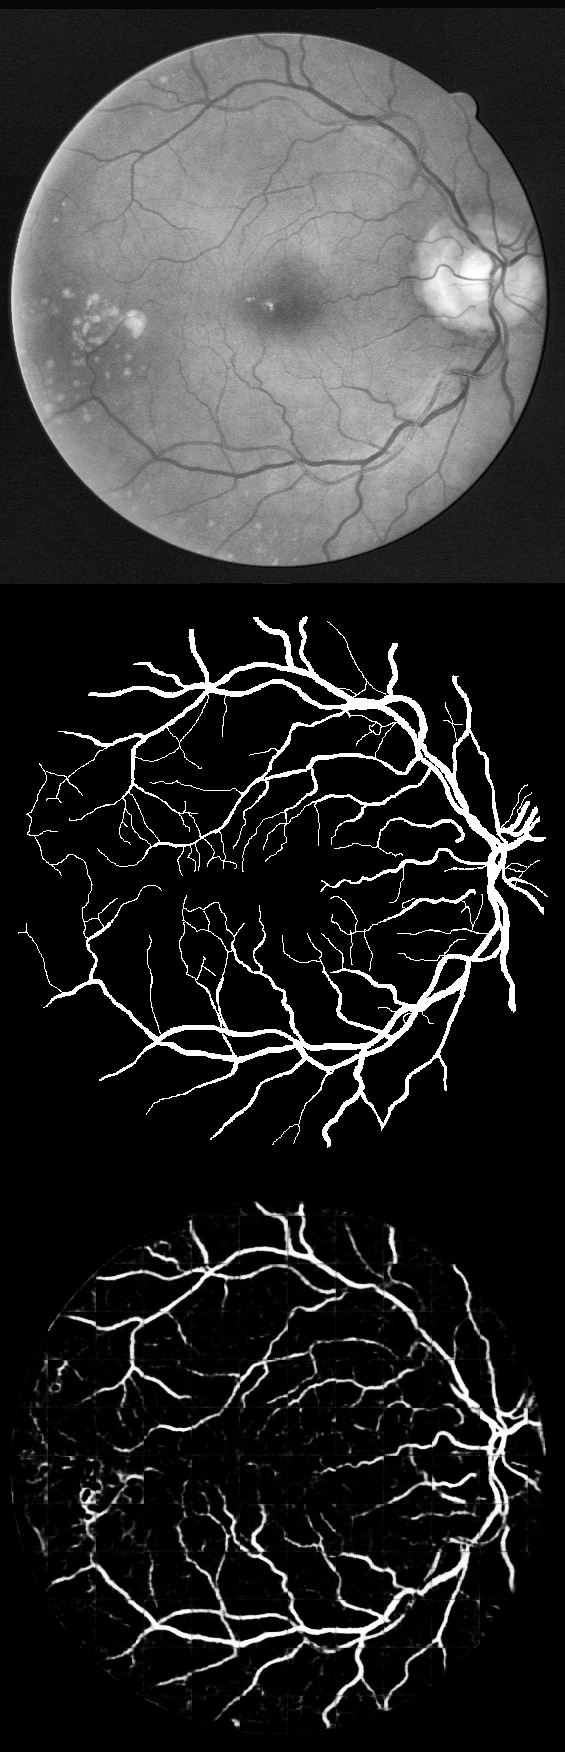

In [79]:
from IPython.display import Image
Image(root_path+'/test/test_Original_GroundTruth_Prediction7.png')